<a href="https://colab.research.google.com/github/ChintanThacker/Facial_Expression_EfficientNet/blob/master/EfficientNet_with_BNM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# a = []
# while(1):
#  a.append('1')

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [1]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tensorflow import keras
from glob import glob
from tqdm import notebook
from sklearn import preprocessing
from keras import Model
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, BatchNormalization
from keras import optimizers
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import sys, os
from sklearn.model_selection import train_test_split
from keras.models import load_model
from keras.models import model_from_json

Using TensorFlow backend.


In [2]:
pip install -U git+https://github.com/qubvel/efficientnet

  Cloning https://github.com/qubvel/efficientnet to /tmp/pip-req-build-dshd5f6e
  Running command git clone -q https://github.com/qubvel/efficientnet /tmp/pip-req-build-dshd5f6e
  Created wheel for efficientnet: filename=efficientnet-1.1.0-cp36-none-any.whl size=18327 sha256=b844759548ca69d50ae69ff05d5fd42f087dd65b0c0027423f52b06a8855ac00
  Stored in directory: /tmp/pip-ephem-wheel-cache-fywbk86t/wheels/64/60/2e/30ebaa76ed1626e86bfb0cc0579b737fdb7d9ff8cb9522663a
Successfully built efficientnet
  Found existing installation: efficientnet 1.1.0
    Uninstalling efficientnet-1.1.0:
      Successfully uninstalled efficientnet-1.1.0


In [0]:
from efficientnet.keras import EfficientNetB7
from efficientnet.keras import preprocess_input

In [0]:
train = '/content/drive/My Drive/train/'
#test = '/content/drive/My Drive/dataset/test'

In [0]:
# del model
eff_net = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [6]:
x = eff_net.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(7, activation='softmax')(x)
model = Model(inputs=eff_net.input, outputs=predictions)
# fix the feature extraction part of the model
for layer in eff_net.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False

model.compile(optimizers.rmsprop(lr=0.0001, decay=0.0001/20),loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 64) 1728        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 64) 256         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 64) 0           stem_bn[0][0]                    
____________________________________________________________________________________________

In [0]:
# x = eff_net.output
# x = Flatten()(x)
# x = Dense(1024, activation="relu")(x)
# x = Dropout(0.5)(x)
# predictions = Dense(7, activation="softmax")(x)
# model = Model(input = eff_net.input, output = predictions)
# model.compile(optimizers.rmsprop(lr=0.0001, decay=1e-6),loss='categorical_crossentropy',metrics=['accuracy'])
# model.summary()

In [0]:
class DataLoader():
  def __init__(self, path):
    self.path = path
  
  def preprocessing(self,instancePath):
    image = load_img(instancePath, target_size=(224, 224))
    image = img_to_array(image)
    image /= 255.0
    image = image.reshape((image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    return image

  def prepare_train_data(self):
    X_train = []
    y_train = []

    for class_folder_name in os.listdir(self.path):
      class_folder_path = os.path.join(self.path, class_folder_name)
      for img in notebook.tqdm(os.listdir(class_folder_path)):
        imgpath = os.path.join(class_folder_path, img)
        img = self.preprocessing(imgpath)
        X_train.append(img)
        y_train.append(class_folder_name)

    X_train = np.asarray(X_train)
    y_train = np.asarray(y_train)
    
    le = preprocessing.LabelEncoder()
    y_train = le.fit_transform(y_train)
    print(np.unique(y_train))   

    print(f'X_train shape:{X_train.shape}\nY_train shape:{y_train.shape}')
    return X_train,y_train

In [0]:
X_train = []
y_train = []
dl = DataLoader(path = train)
X_train, y_train = dl.prepare_train_data()


[0 1 2 3 4 5 6]
X_train shape:(2900, 224, 224, 3)
Y_train shape:(2900,)


In [0]:
import numpy as np
#np.save('/content/drive/My Drive/EfficientNet/X_train.npy', X_train)
#np.save('/content/drive/My Drive/EfficientNet/y_train.npy', y_train)

In [0]:
#print(f'X_train shape:{X_train.shape}\nY_train shape:{y_train.shape}')

In [0]:
X_train = np.load('/content/drive/My Drive/EfficientNet/X_train.npy')
y_train = np.load('/content/drive/My Drive/EfficientNet/y_train.npy')

In [9]:
from keras.utils import to_categorical
y_train = to_categorical(y_train, 7)
print(f'X_train shape:{X_train.shape}\nY_train shape:{y_train.shape}')

X_train shape:(2900, 224, 224, 3)
Y_train shape:(2900, 7)


In [10]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
# sss = StratifiedShuffleSplit(n_splits=1, test_size=0.16, random_state=42) # Want a balanced split for all the classes
# for train_index, test_index in sss.split(x_train, y_train):
#     print("Using {} for training and {} for validation".format(len(train_index), len(test_index)))
#     x_train, x_valid = x_train[train_index], x_train[test_index]
#     y_train, y_valid = y_train[train_index], y_train[test_index]


print(f'X_train shape:{x_train.shape}\nY_train shape:{y_train.shape}\nX_valid shape:{x_valid.shape}\nY_valid shape:{y_valid.shape}')

X_train shape:(2610, 224, 224, 3)
Y_train shape:(2610, 7)
X_valid shape:(290, 224, 224, 3)
Y_valid shape:(290, 7)


In [0]:
nb_epoch = 50
learning_rate = 0.0001
batch_size = 6
weights="/content/drive/My Drive/EfficientNet/effnetwithBN.h5"
callbacks = [ModelCheckpoint(weights, monitor='val_loss', save_best_only=True, verbose=0)]

In [12]:
%%time
# Train model
history = model.fit(x_train , y_train, batch_size=batch_size,epochs=nb_epoch,validation_data=(x_valid, y_valid),verbose=1, callbacks=callbacks, use_multiprocessing=True)

Train on 2610 samples, validate on 290 samples
Epoch 1/50
2610/2610 [==============================] - 198s 76ms/step - loss: 1.9505 - accuracy: 0.1655 - val_loss: 1.9736 - val_accuracy: 0.1138
Epoch 2/50
2610/2610 [==============================] - 146s 56ms/step - loss: 1.9113 - accuracy: 0.2088 - val_loss: 1.8915 - val_accuracy: 0.2138
Epoch 3/50
2610/2610 [==============================] - 145s 56ms/step - loss: 1.8908 - accuracy: 0.2375 - val_loss: 1.8801 - val_accuracy: 0.2138
Epoch 4/50
2610/2610 [==============================] - 146s 56ms/step - loss: 1.8616 - accuracy: 0.2759 - val_loss: 1.8348 - val_accuracy: 0.3310
Epoch 5/50
2610/2610 [==============================] - 146s 56ms/step - loss: 1.8307 - accuracy: 0.3011 - val_loss: 1.7920 - val_accuracy: 0.3345
Epoch 6/50
2610/2610 [==============================] - 146s 56ms/step - loss: 1.7960 - accuracy: 0.3234 - val_loss: 1.7622 - val_accuracy: 0.3414
Epoch 7/50
2610/2610 [==============================] - 145s 56ms/step 

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

print('Training acc:{}'.format(max(acc)))
print('Validation acc:{}'.format(max(val_acc)))

print('Training loss:{}'.format(max(loss)))
print('Vallidation loss:{}'.format(max(val_loss)))

Training acc:0.6590038537979126
Validation acc:0.7103448510169983
Training loss:1.9504552024534378
Vallidation loss:1.9735598333950701


In [14]:
#saving the model
fer_json = model.to_json()
with open("/content/drive/My Drive/EfficientNet/fer.json", "w") as json_file:
  json_file.write(fer_json)
model.save_weights("/content/drive/My Drive/EfficientNet/fer.h5")
print("Saved Model to Disk")

Saved Model to Disk


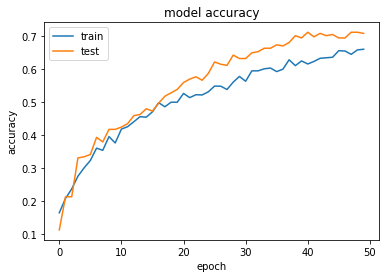

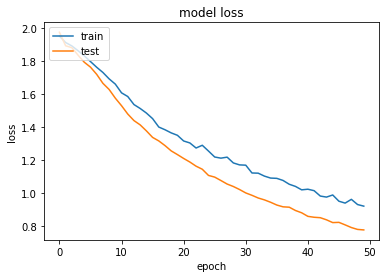

In [15]:
import pandas as pd
history_df = pd.DataFrame(model.history.history)
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
top5_trainacc = history_df["accuracy"].sort_values(ascending=False)[:5]
top5_valacc = history_df["val_accuracy"].sort_values(ascending=False)[:5]

In [17]:
Top5results = pd.DataFrame({'train_Top5 Acc': list(top5_trainacc), 'val_Top5 Acc' : list(top5_valacc)})
Top5results

,train_Top5 Acc,val_Top5 Acc
0,0.659004,0.710345
1,0.657088,0.710345
2,0.654789,0.710345
3,0.653640,0.706897
4,0.643678,0.706897


In [18]:
score = model.evaluate(x_valid, y_valid, verbose=1)

290/290 [==============================] - 4s 13ms/step


In [19]:
print(f'Val_loss : {score[0]}\nVal_Acc: {score[1]}')

Val_loss : 0.7758074694666369
Val_Acc: 0.7068965435028076


In [0]:
y_pred = np.argmax(model.predict(x_valid), axis=1)
y_valid = np.argmax(y_valid, axis=1)

In [0]:
from sklearn.metrics import classification_report, confusion_matrix

In [22]:
print('Confusion Matrix')
print(confusion_matrix(y_valid, y_pred))
print('Classification Report')
target_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
print(classification_report(y_valid, y_pred, target_names=target_names))

Confusion Matrix
[[20  1  3  3  4  6  0]
 [ 3 21  2  3  1  9  0]
 [ 2  1 20  6  0  1 10]
 [ 0  2  1 42  2  2  0]
 [ 0  1  2  0 42  4  2]
 [ 4  0  0  2  4 29  0]
 [ 0  0  3  0  1  0 31]]
Classification Report
              precision    recall  f1-score   support

       Angry       0.69      0.54      0.61        37
     Disgust       0.81      0.54      0.65        39
        Fear       0.65      0.50      0.56        40
       Happy       0.75      0.86      0.80        49
     Neutral       0.78      0.82      0.80        51
         Sad       0.57      0.74      0.64        39
    Surprise       0.72      0.89      0.79        35

    accuracy                           0.71       290
   macro avg       0.71      0.70      0.69       290
weighted avg       0.71      0.71      0.70       290



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Text(33.0, 0.5, "('Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise')")

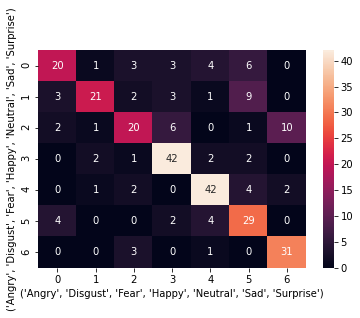

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

ax = sns.heatmap(confusion_matrix(y_valid, y_pred), annot=True, fmt="d")
ax.set_xlabel(tuple(target_names))
ax.set_ylabel(tuple(target_names))